In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import itertools
import sys
sys.path.insert(0, '..')
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15, 8)
plt.rcParams['font.size'] = 16
import numpy as np
import pandas as pd
import requests
import seaborn as sns

import covid19

## data

In [3]:
data_italy_regions_path = 'dpc-covid19-ita-regioni.csv'
data_italy_regions_path = covid19.data.download('regioni')
df_italy_regions = pd.read_csv(data_italy_regions_path, parse_dates=['data'], index_col=['data'])

df_italy_regions.index = df_italy_regions.index.normalize()
REGIONS = df_italy_regions.loc[df_italy_regions.index.max()].sort_values('ricoverati_con_sintomi', ascending=False)['denominazione_regione'].tolist()
print(REGIONS)
df_italy_regions.tail()

['Lombardia', 'Emilia-Romagna', 'Piemonte', 'Veneto', 'Lazio', 'Liguria', 'Toscana', 'Marche', 'Campania', 'Puglia', 'Sicilia', 'Abruzzo', 'P.A. Trento', 'P.A. Bolzano', 'Calabria', 'Friuli Venezia Giulia', 'Umbria', "Valle d'Aosta", 'Sardegna', 'Basilicata', 'Molise']


,stato,codice_regione,denominazione_regione,lat,long,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_positivi,variazione_totale_positivi,nuovi_positivi,dimessi_guariti,deceduti,totale_casi,tamponi,note_it,note_en
data,,,,,,,,,,,,,,,,,,
2020-04-13,ITA,9,Toscana,43.769231,11.255889,992,225,1217,5040,6257,95,155,615,518,7390,80889,NaN,NaN
2020-04-13,ITA,4,P.A. Trento,46.068935,11.121231,326,56,382,1698,2080,-2,73,746,300,3126,18586,NaN,NaN
2020-04-13,ITA,10,Umbria,43.106758,12.388247,127,38,165,460,625,-62,1,643,52,1320,18740,NaN,NaN
2020-04-13,ITA,2,Valle d'Aosta,45.737503,7.320149,109,15,124,458,582,-6,6,230,115,927,3614,NaN,NaN
2020-04-13,ITA,5,Veneto,45.434905,12.338452,1427,245,1672,9094,10766,37,174,2603,882,14251,203077,NaN,NaN


In [4]:
data = {region: df_italy_regions[df_italy_regions['denominazione_regione'] == region] for region in REGIONS}
for dr in data.values():
    dr['variazione_ricoverati_con_sintomi'] = dr['ricoverati_con_sintomi'].diff(1)
    dr['variazione_deceduti'] = dr['deceduti'].diff(1)
    dr['variazione_deceduti_4'] = dr['variazione_deceduti'].rolling(window=4).mean()

df_italy_regions.loc[df_italy_regions.index.max()].sort_values('deceduti', ascending=False)[['denominazione_regione', 'ricoverati_con_sintomi', 'terapia_intensiva', 'deceduti']]


,denominazione_regione,ricoverati_con_sintomi,terapia_intensiva,deceduti
data,,,,
2020-04-13,Lombardia,12028,1143,10901
2020-04-13,Emilia-Romagna,3490,331,2615
2020-04-13,Piemonte,3344,379,1826
2020-04-13,Veneto,1427,245,882
2020-04-13,Liguria,1088,138,760
2020-04-13,Marche,959,108,713
2020-04-13,Toscana,992,225,518
2020-04-13,P.A. Trento,326,56,300
2020-04-13,Lazio,1314,200,284


In [5]:
DAY = np.timedelta64(24 * 60 * 60, 's')
PALETTE_ONE = list(sns.color_palette())

SHOWUNTIL = np.datetime64(df_italy_regions.index.max(), 's') + 3 * DAY

EXTENT = ('2020-02-23', SHOWUNTIL)
XLIM = tuple(map(np.datetime64, EXTENT))

In [6]:
REGIONS_FIT_PARAMS = {
    'Lombardia': {
        'ricoverati_con_sintomi': [None, '2020-03-07', '2020-03-08', '2020-03-18'],
        'terapia_intensiva': 0,
        'deceduti': 4,
    },
    'Emilia-Romagna': {
        'ricoverati_con_sintomi': [None, '2020-03-06', '2020-03-21'],
        'terapia_intensiva': 0,
        'deceduti': [None, '2020-03-23'],
    },
    'Piemonte': {
        'ricoverati_con_sintomi': [None, '2020-03-20', '2020-03-21'],
        'terapia_intensiva': 0,
        'deceduti': 4,
    },
    'Veneto': {
        'ricoverati_con_sintomi': [None, '2020-03-13', '2020-03-14', '2020-03-24'],
        'terapia_intensiva': 0,
        'deceduti': 4,
    },
    'Marche': {
        'ricoverati_con_sintomi': [None, '2020-03-16', '2020-03-21'],
        'terapia_intensiva': 0,
        'deceduti': 4,
    },
    'Liguria': {
        'ricoverati_con_sintomi': [None, '2020-03-21'],
        'terapia_intensiva': 0,
        'deceduti': 4,
    },
    'Toscana': {
        'ricoverati_con_sintomi': [None, '2020-03-19'],
        'terapia_intensiva': 0,
        'deceduti': 4,
    },
    'Lazio': {
        'ricoverati_con_sintomi': [None, '2020-03-21', '2020-03-28'],
        'terapia_intensiva': 0,
        'deceduti': 4,
    },
    'P.A. Trento': {
        'ricoverati_con_sintomi': [None, '2020-03-21'],
        'terapia_intensiva': 0,
        'deceduti': 4,
    },
    'Campania': {
        'ricoverati_con_sintomi': [None, '2020-03-26'],
        'terapia_intensiva': 0,
        'deceduti': 4,
    },
    'Puglia': {
        'ricoverati_con_sintomi': [None, '2020-03-16', '2020-03-26'],
        'terapia_intensiva': 0,
        'deceduti': 4,
    },
    'Sicilia': {
        'ricoverati_con_sintomi': [None, '2020-03-21', None],
        'terapia_intensiva': 0,
        'deceduti': 4,
    },
    'Abruzzo': {
        'ricoverati_con_sintomi': [None, '2020-03-21', None],
        'terapia_intensiva': 0,
        'deceduti': 4,
    },
    'Friuli Venezia Giulia': {
        'ricoverati_con_sintomi': [None, '2020-03-16', '2020-03-24', None],
        'terapia_intensiva': 0,
        'deceduti': ['2020-03-20', '2020-03-31', None],
    },
    'P.A. Bolzano': {
        'ricoverati_con_sintomi': [None, '2020-03-21'],
        'terapia_intensiva': 0,
        'deceduti': 4,
    },
    'Umbria': {
        'ricoverati_con_sintomi': [None, '2020-03-21'],
        'terapia_intensiva': 0,
        'deceduti': 4,
    },
    'Calabria': {
        'ricoverati_con_sintomi': [None, '2020-03-21'],
        'terapia_intensiva': 0,
        'deceduti': 4,
    },
    'Sardegna': {
        'ricoverati_con_sintomi': [None, '2020-03-21'],
        'terapia_intensiva': 0,
        'deceduti': 4,
    },
    'Valle d\'Aosta': {
        'ricoverati_con_sintomi': [None, '2020-03-21'],
        'terapia_intensiva': 0,
        'deceduti': 4,
    },
    'Basilicata': {
        'ricoverati_con_sintomi': [None, '2020-03-21'],
        'terapia_intensiva': 0,
        'deceduti': 4,
    },
    'Molise': {
        'ricoverati_con_sintomi': [None, '2020-03-21'],
        'terapia_intensiva': 0,
        'deceduti': 4,
    },
}
RATIO = {
    'ricoverati_con_sintomi': 35,
    'terapia_intensiva': 6.5,
    'variazione_deceduti': 1,
}
LABEL = {
    'ricoverati_con_sintomi': 'Pazienti attualmente in reparto',
    'terapia_intensiva': 'Pazienti attualmente in terapia intensiva',
    'variazione_deceduti': 'Decessi giornalieri',
}

In [7]:
STOP_FIT = '2020-04-03'

region_fits = {}
for region, params in REGIONS_FIT_PARAMS.items():
    region_fits[region] = {}
    for kind, breaks in params.items():
        if kind == 'deceduti':
            kind = 'variazione_deceduti'
        if isinstance(breaks, int):
            breaks = [np.datetime64(b) + breaks * DAY if b is not None else b for b in params['ricoverati_con_sintomi']]
        region_fits[region][kind] = covid19.fit.fit_exponential_segments(data[region][kind], breaks=breaks)

skipping start=None stop=2020-03-24T00:00:00
skipping start=None stop=2020-03-24T00:00:00
skipping start=None stop=2020-03-24T00:00:00
skipping start=None stop=2020-03-24T00:00:00


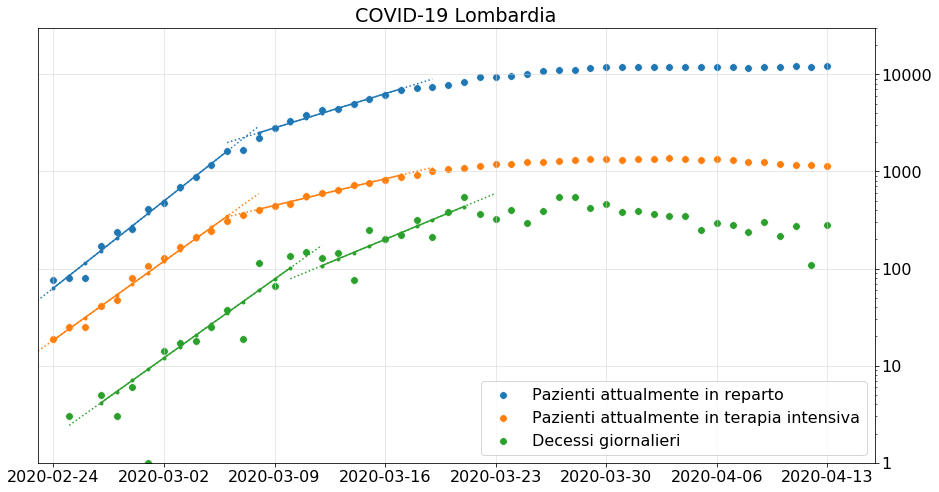

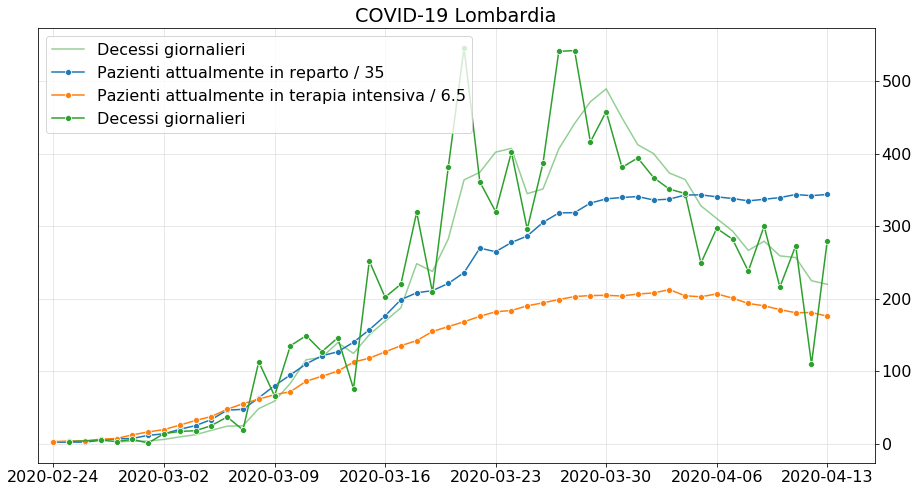

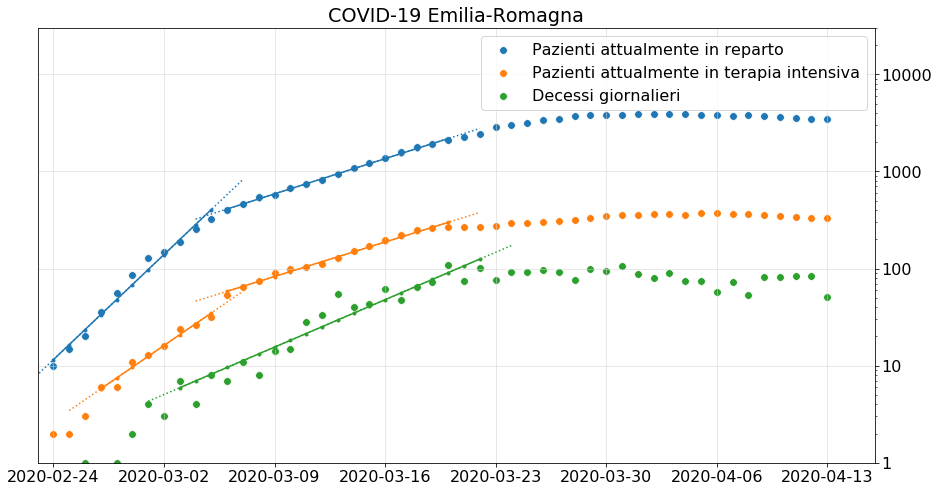

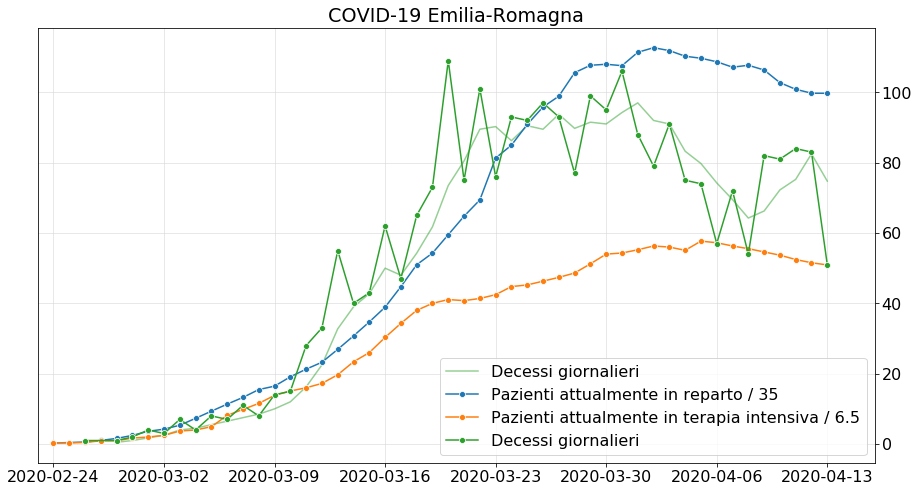

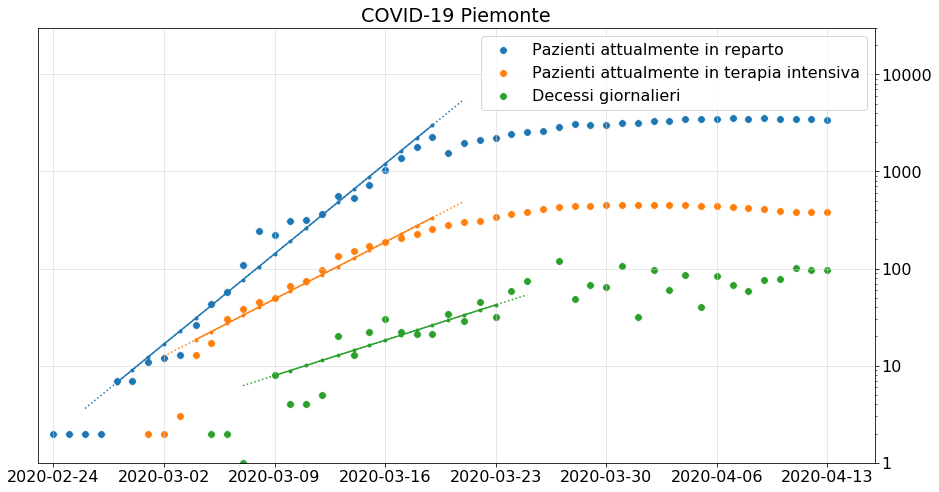

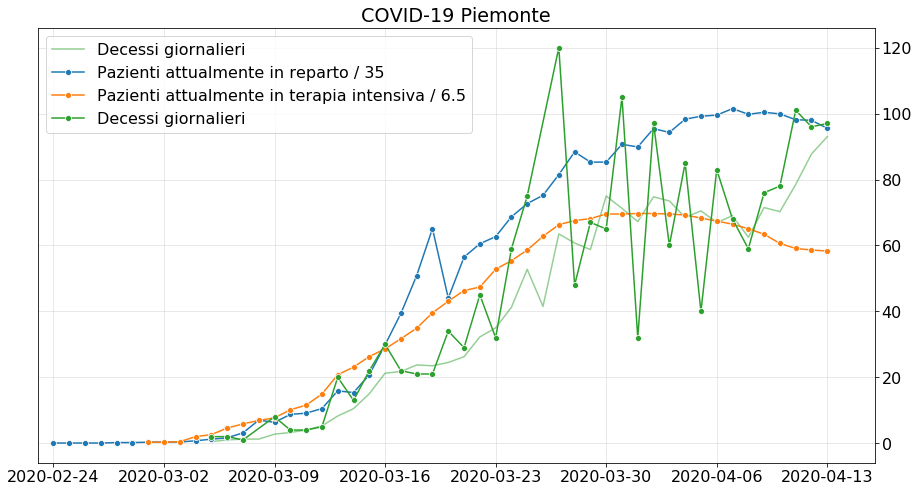

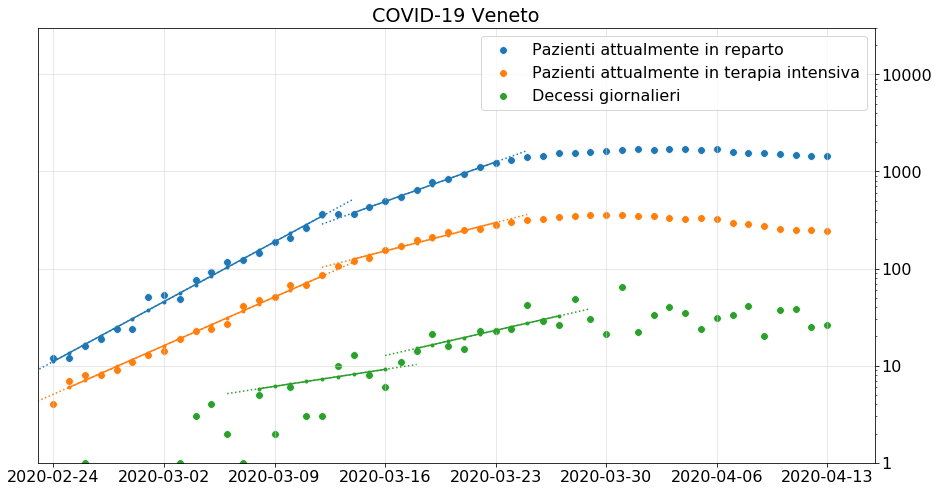

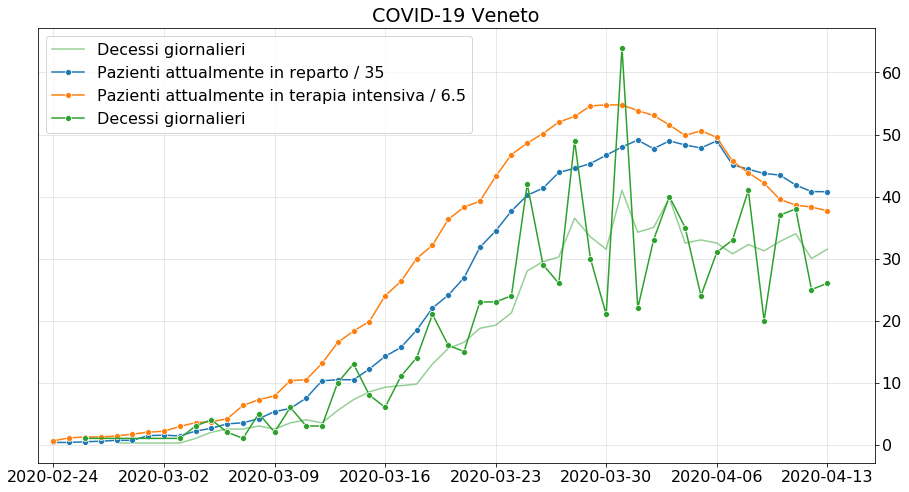

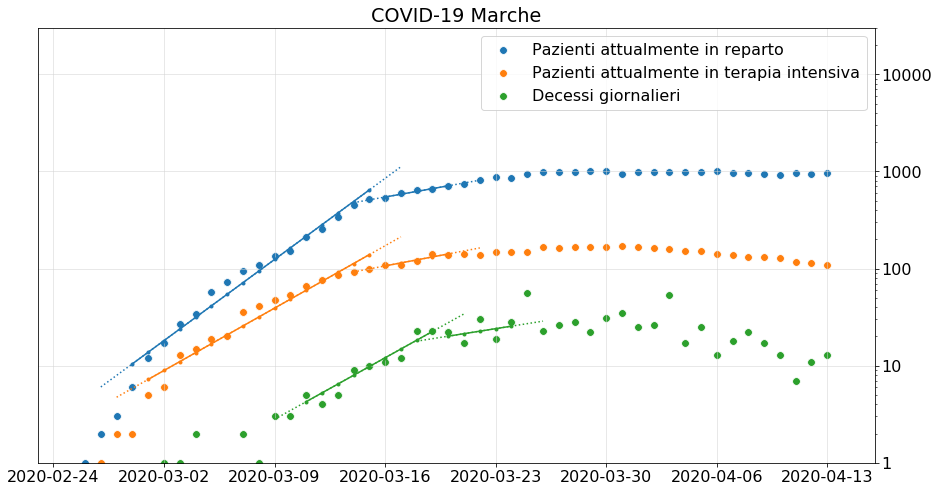

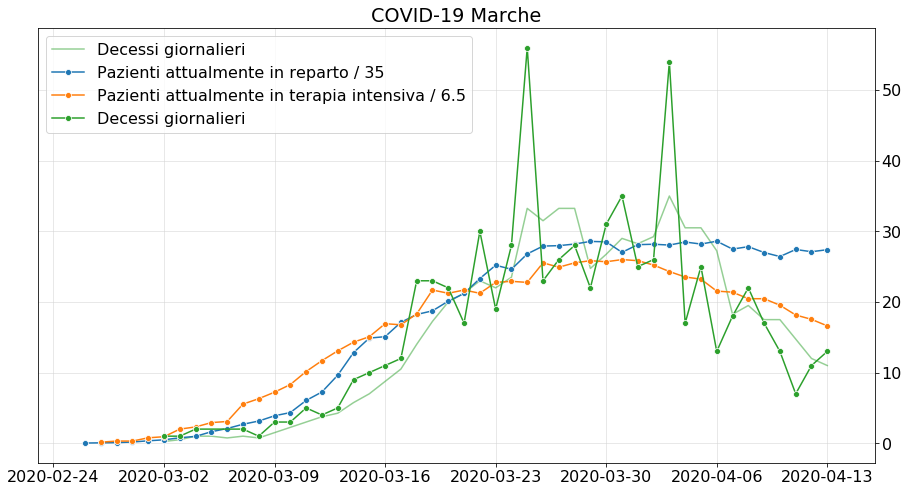

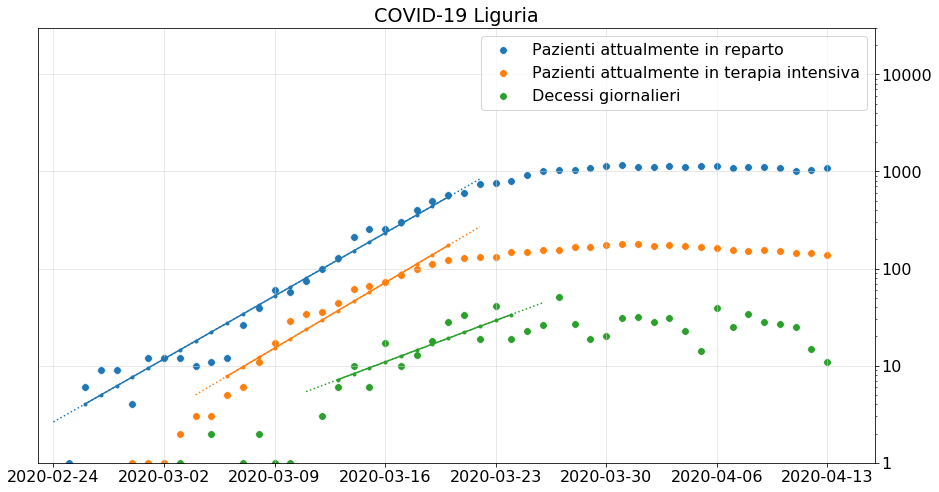

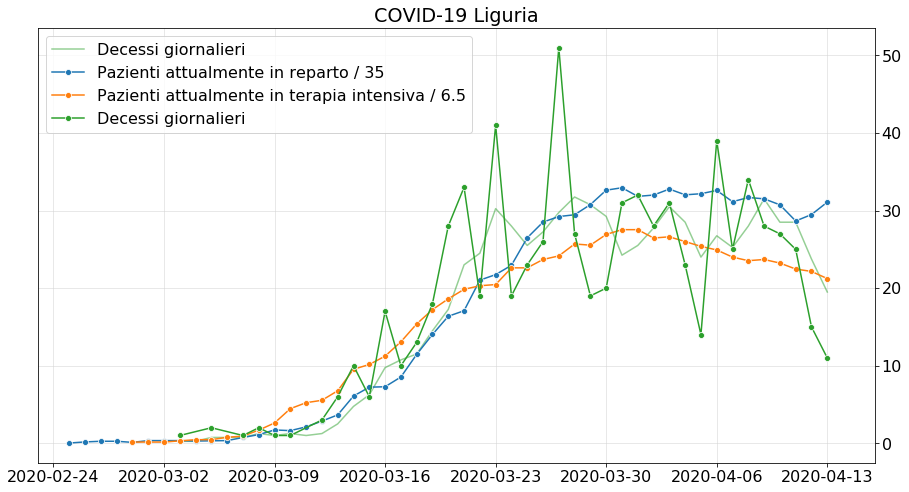

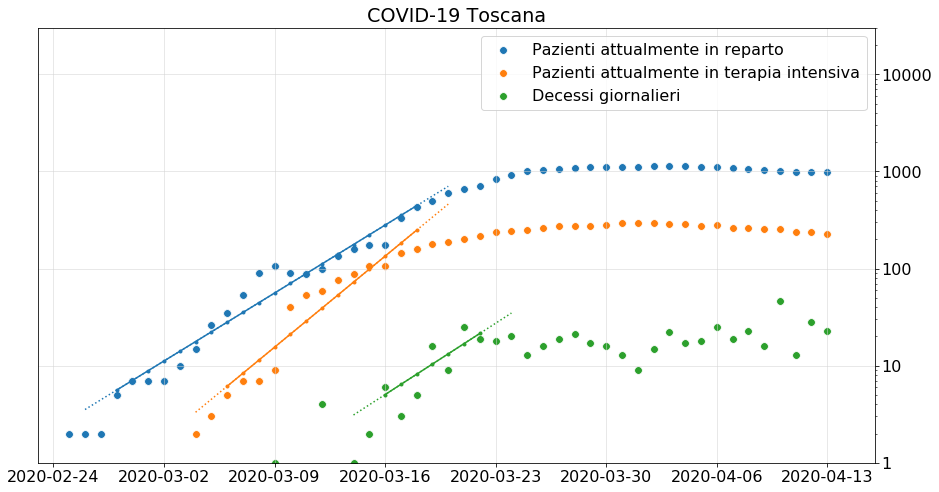

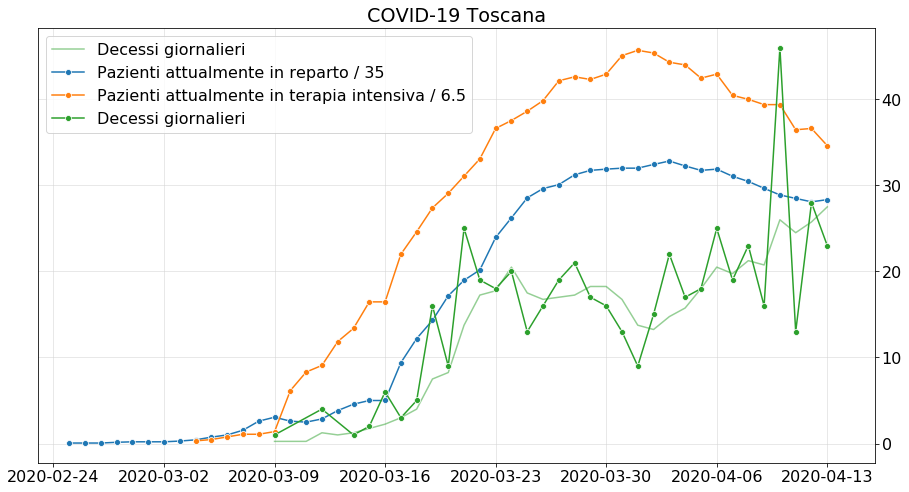

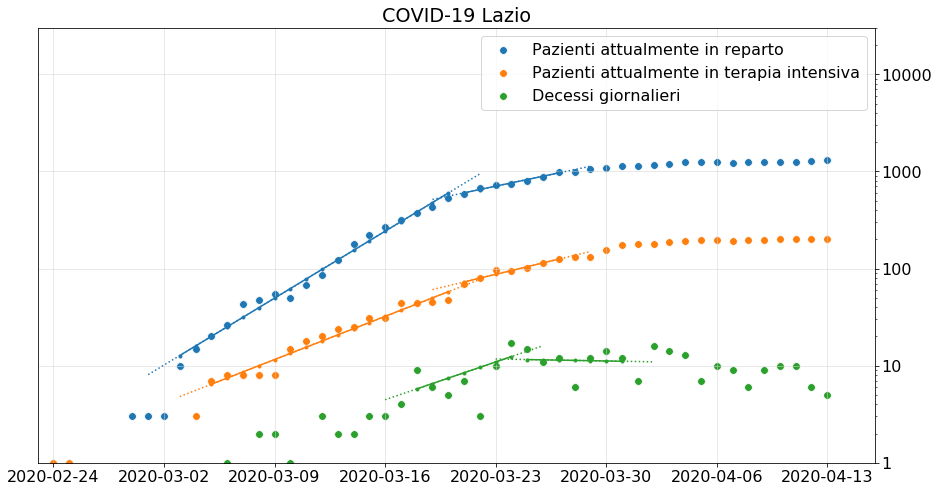

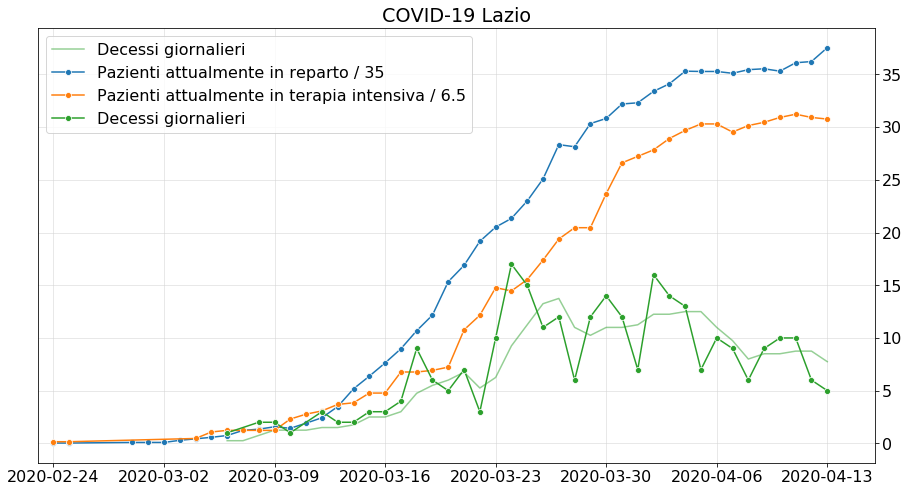

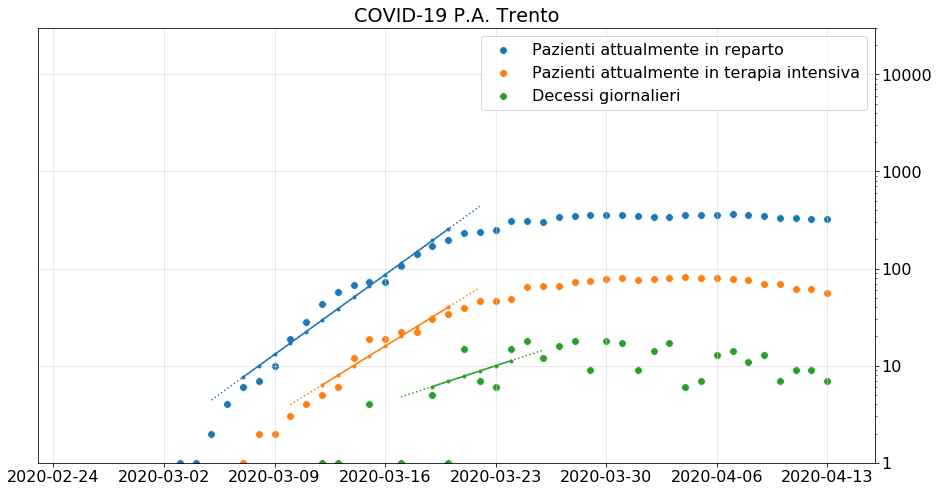

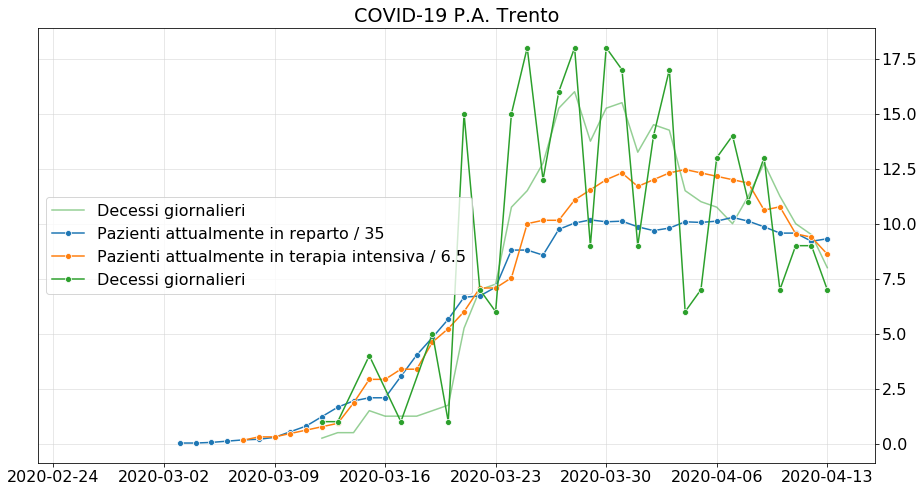

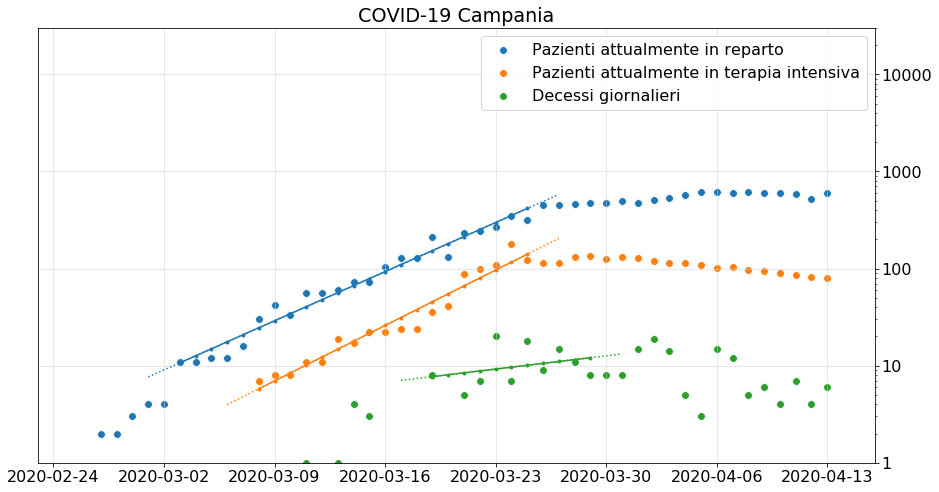

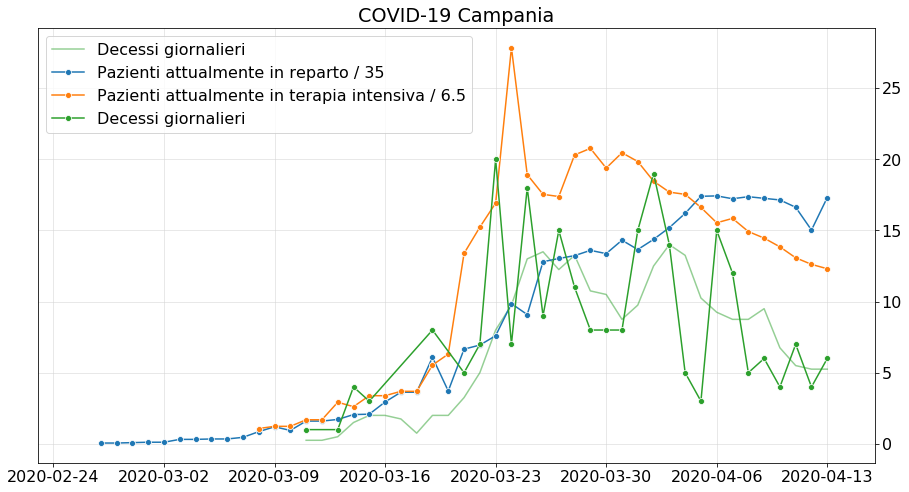

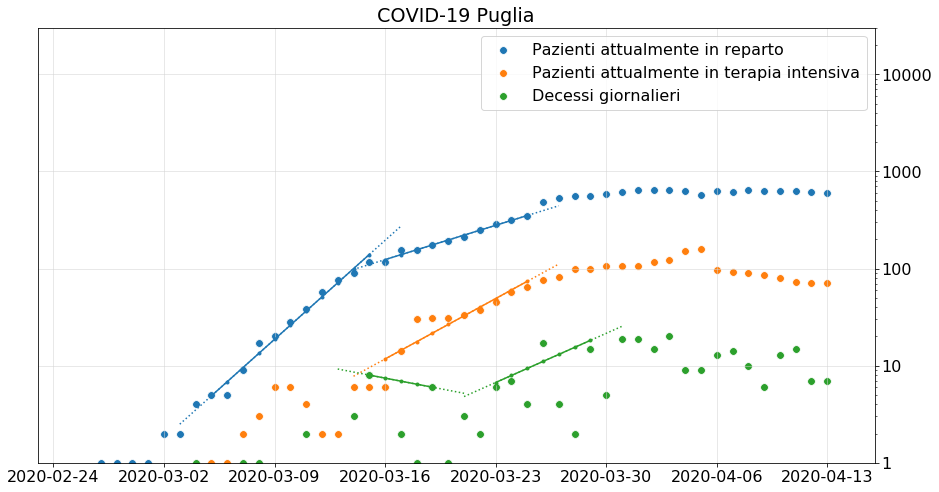

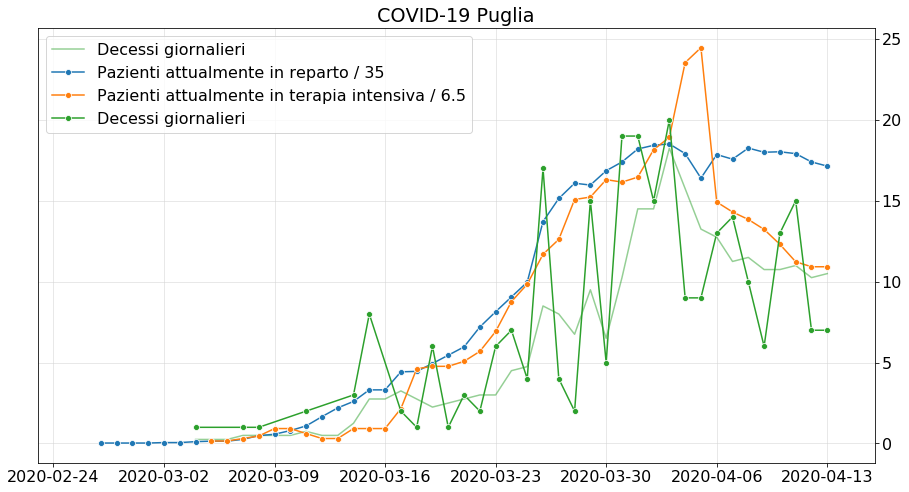

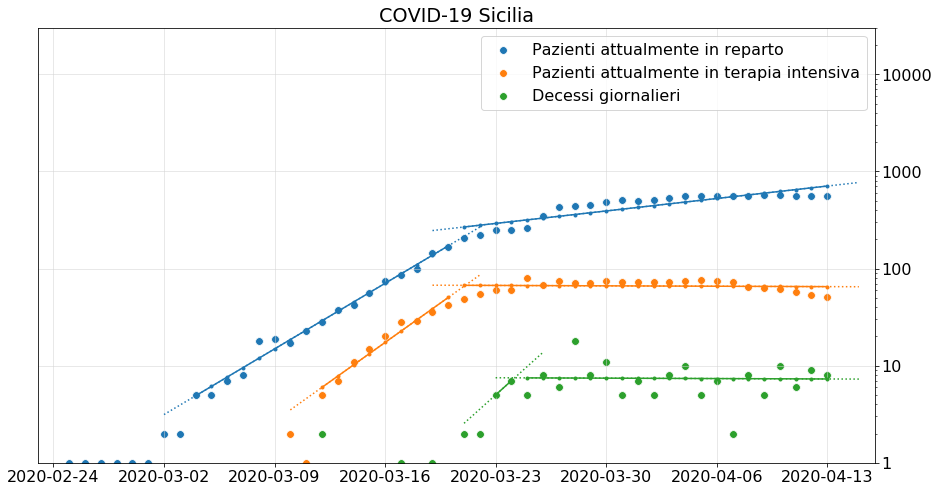

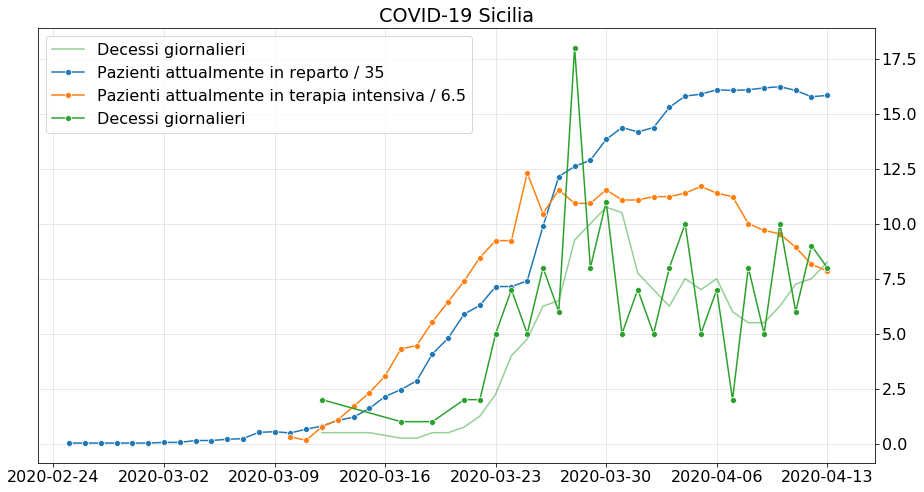

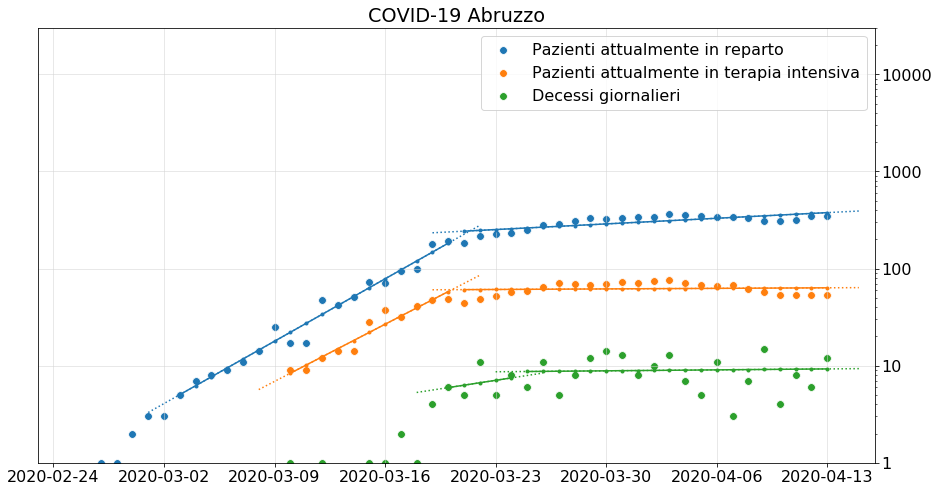

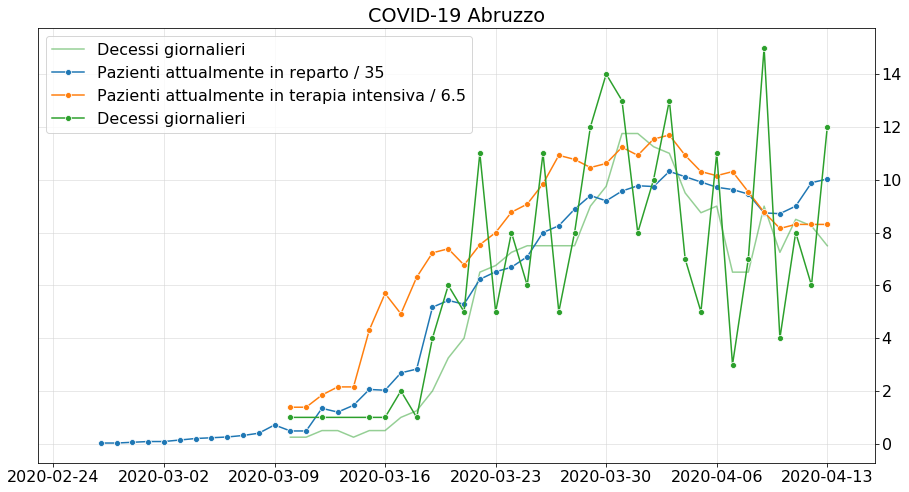

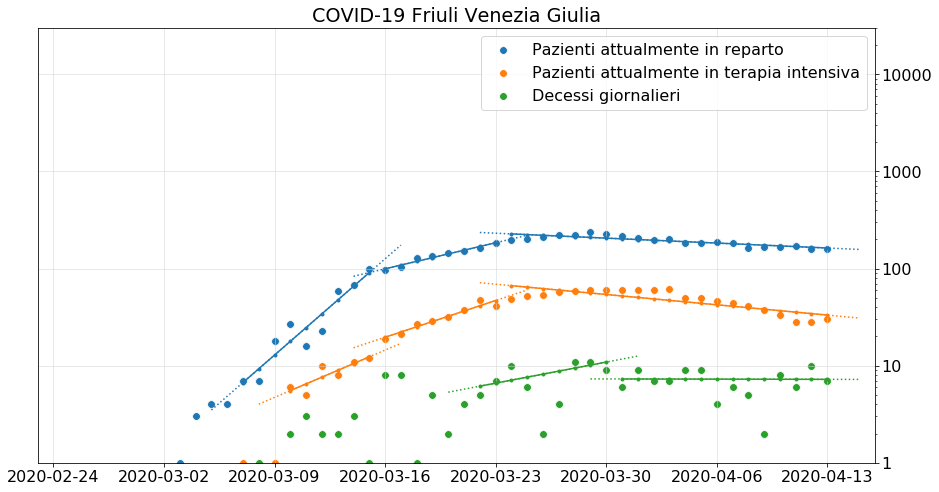

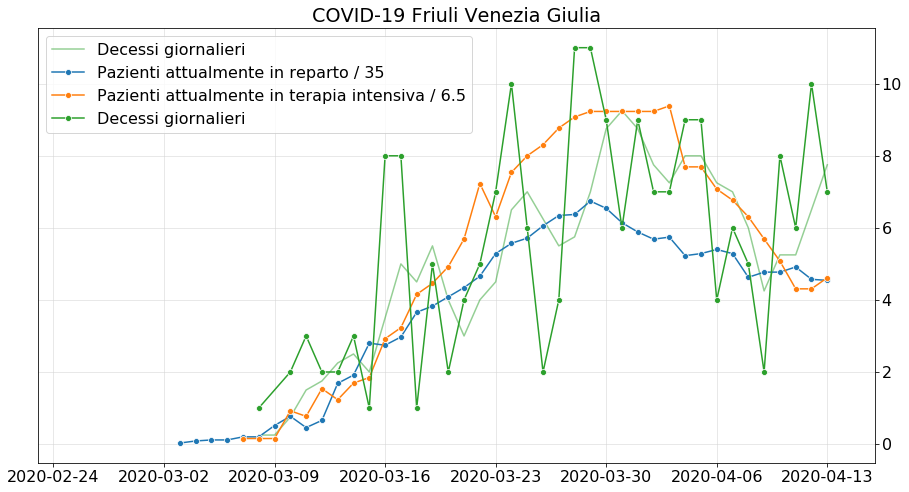

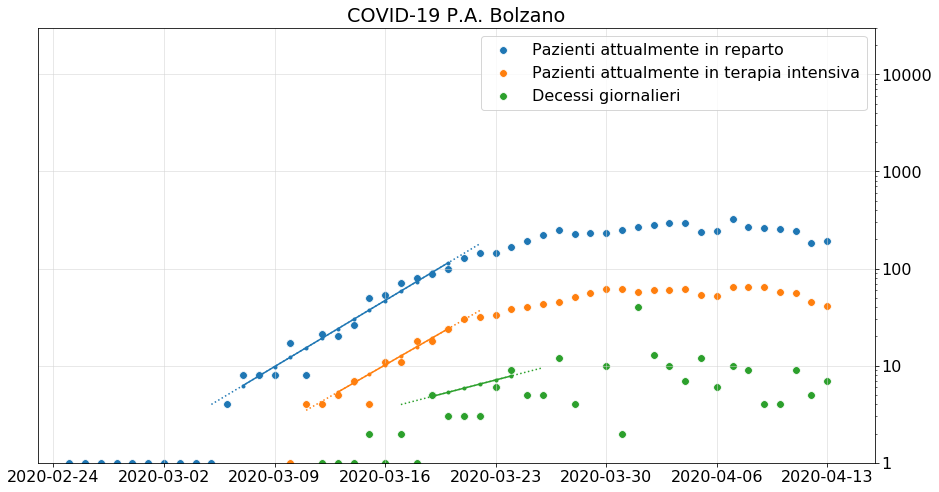

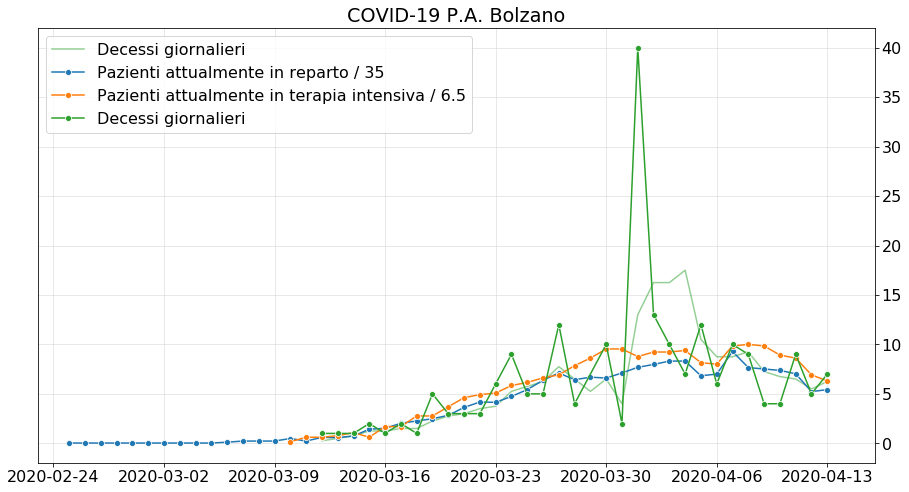

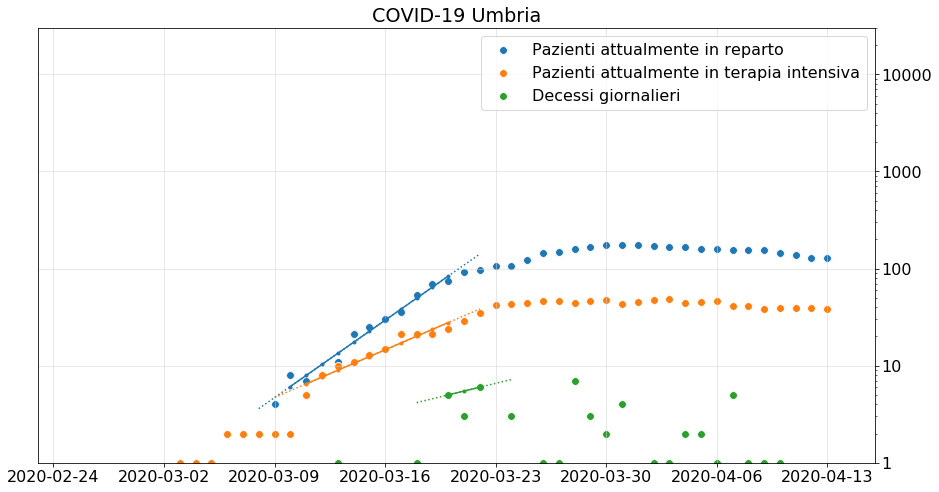

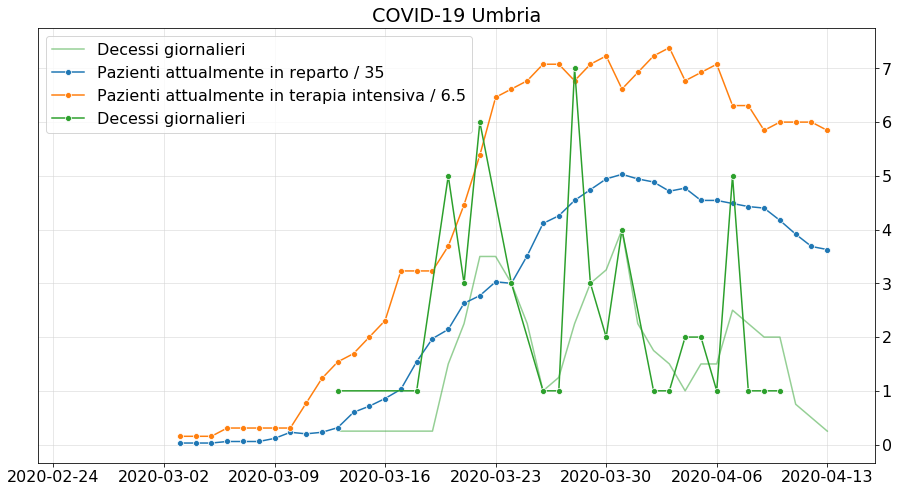

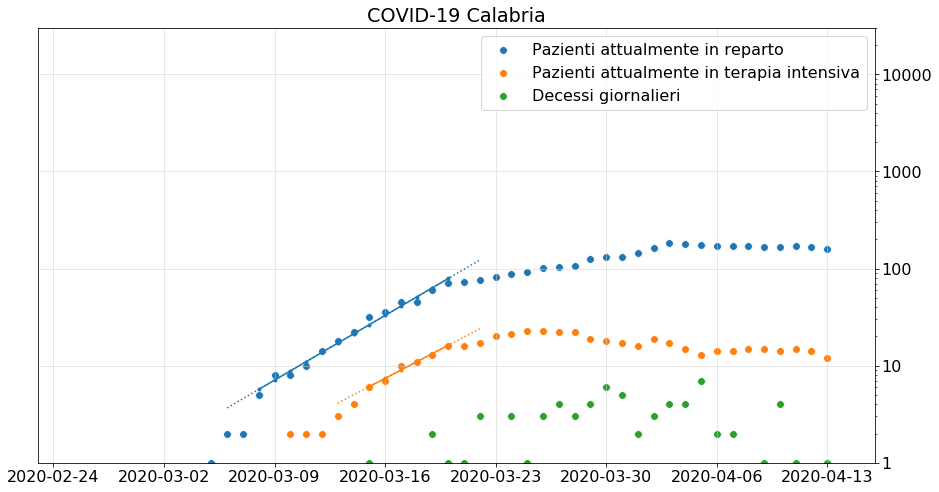

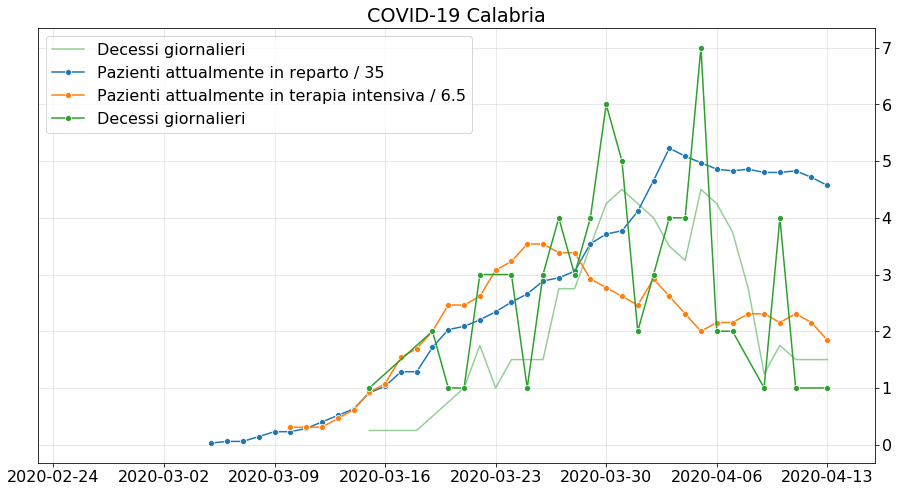

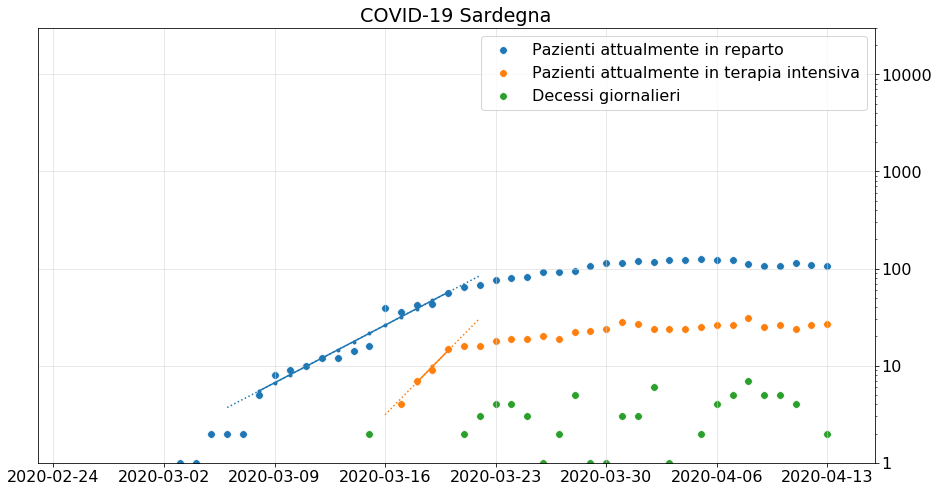

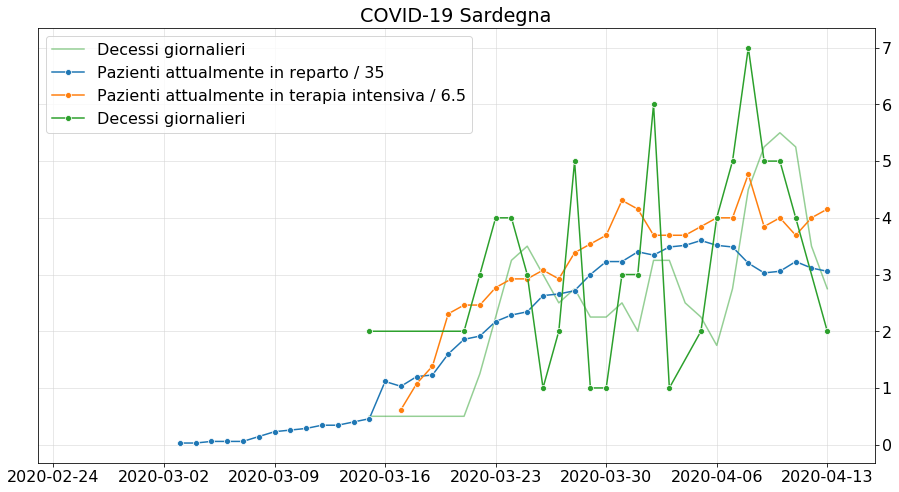

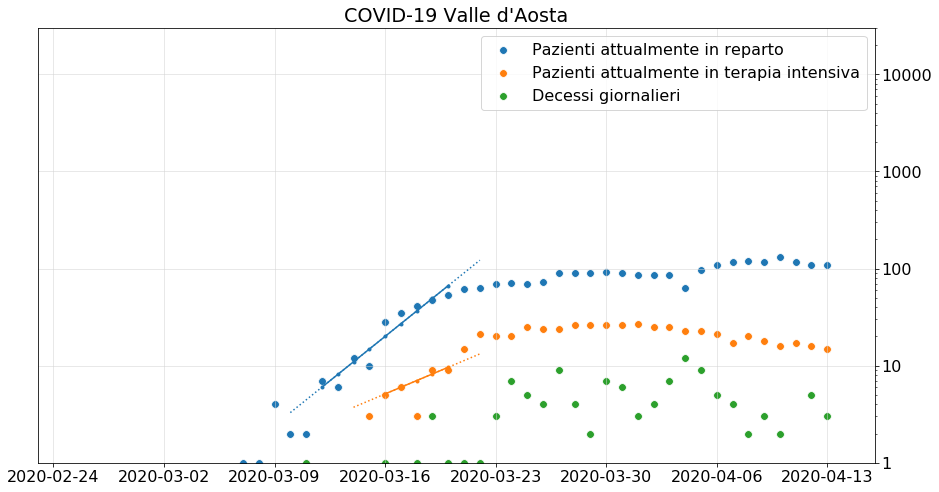

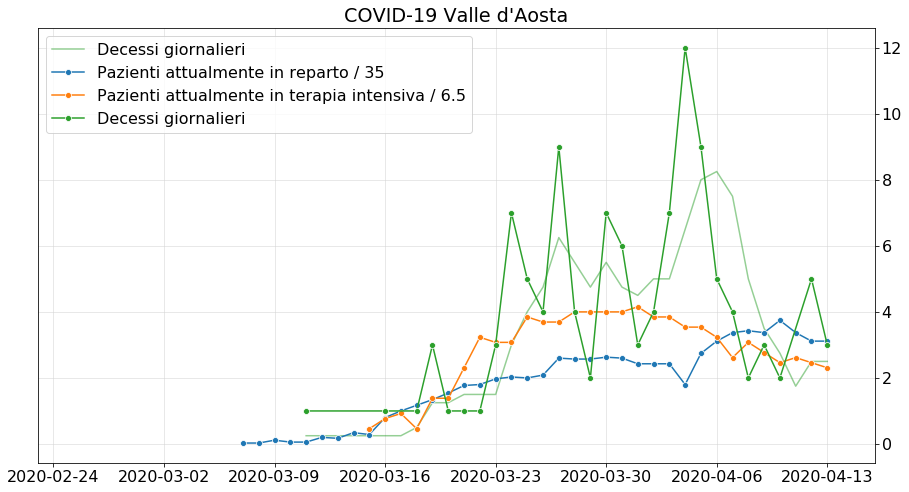

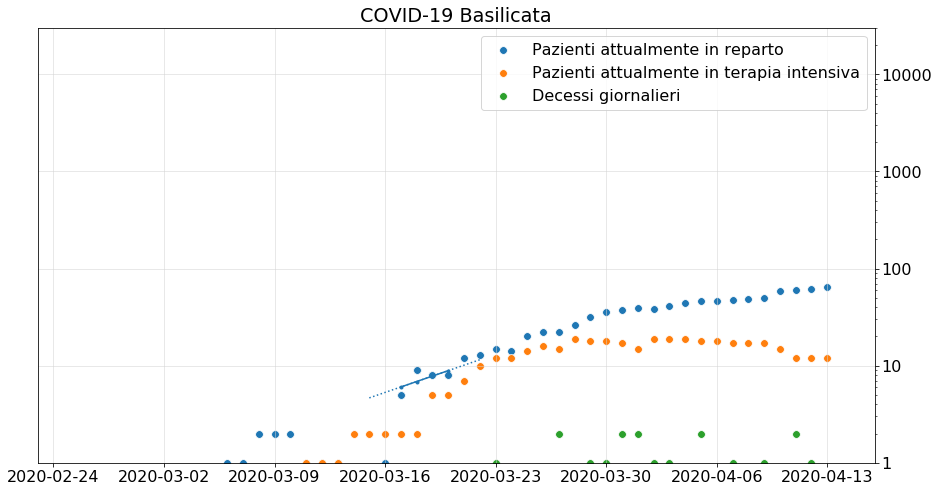

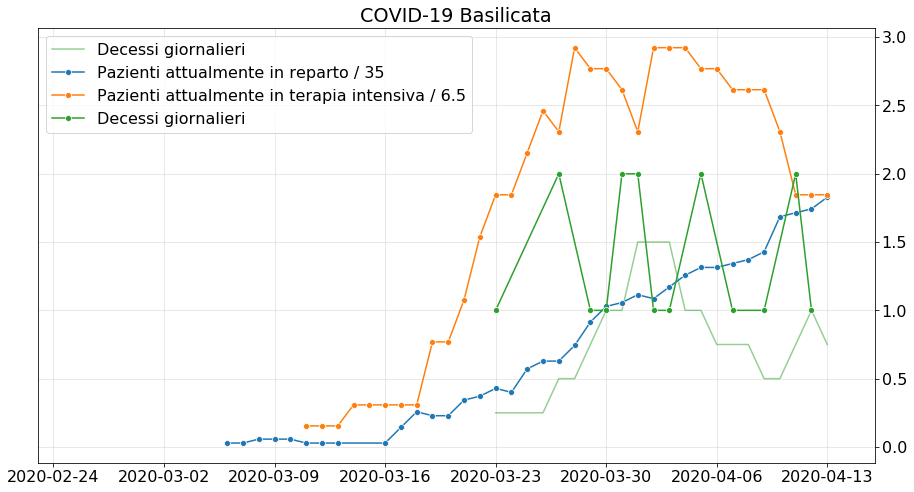

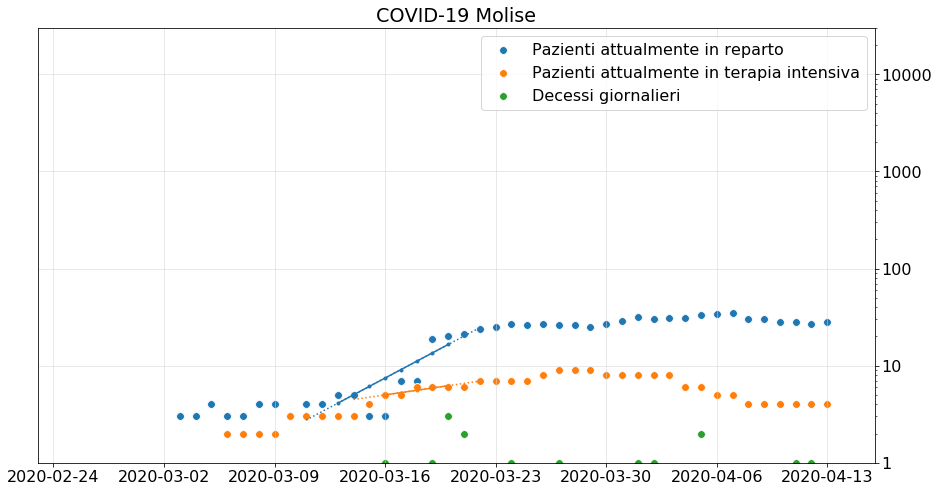

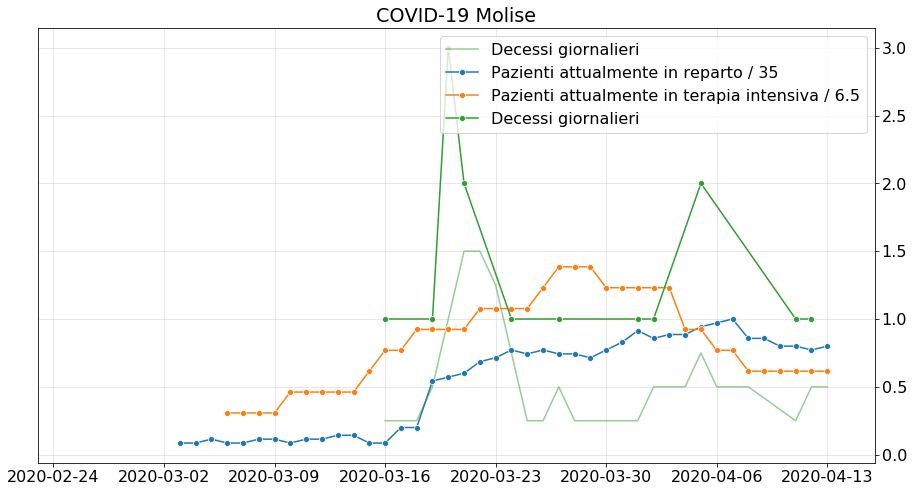

In [12]:
for region, fit_kinds in list(region_fits.items()):
    _, ax = plt.subplots(1, subplot_kw={'xlim': XLIM})
    ax.set(yscale='log', ylim=(1, 30000)) 
    ax.set_title(f'COVID-19 {region}')
    ax.yaxis.tick_right()
    ax.yaxis.grid(color='lightgrey', linewidth=0.5)
    ax.xaxis.grid(color='lightgrey', linewidth=0.5)

    for (kind, fits), color in zip(fit_kinds.items(), PALETTE_ONE):
        label = LABEL[kind]
        covid19.plot.plot_data(ax, data[region][kind], label=label, color=color)
        for fit in fits:
            covid19.plot.plot(ax, data[region][kind], fit, color=color, date_interval=7, add_diff=False)

    _, ax = plt.subplots(1, subplot_kw={'xlim': XLIM})
    ax.set_title(f'COVID-19 {region}')
    ax.yaxis.tick_right()
    ax.yaxis.grid(color='lightgrey', linewidth=0.5)
    ax.xaxis.grid(color='lightgrey', linewidth=0.5)

    covid19.plot.plot_data(ax, data[region]['variazione_deceduti_4'], label=label, kind='line', color=color, alpha=0.5)
    for (kind, fits), color in zip(fit_kinds.items(), PALETTE_ONE):
        ratio = RATIO[kind]
        label = LABEL[kind] + ('' if ratio == 1 else f' / {ratio}')
        covid19.plot.plot_data(ax, data[region][kind] / ratio, label=label, kind='line', marker='o', color=color)
        # for fit in fits:
        #     covid19.plot.plot(ax, data[region][kind] / ratio, fit.scale(1 / ratio), color=color, date_interval=7, add_diff=False)


In [9]:
print('## Initial exponential speed')
for region, fit_kinds in region_fits.items():
    if len(fit_kinds['variazione_deceduti']):
        print(f'{region}:{" " * (14 - len(region))} {str(fit_kinds["variazione_deceduti"][0])}')

## Initial exponential speed
Lombardia:      T_d=2.60 t_0='2020-02-21' r^2=0.937 start='2020-02-27' stop='2020-03-10'
Emilia-Romagna: T_d=4.32 t_0='2020-02-20' r^2=0.960 start='2020-03-03' stop='2020-03-22'
Piemonte:       T_d=5.80 t_0='2020-02-20' r^2=0.823 start='2020-03-09' stop='2020-03-23'
Veneto:         T_d=12.05 t_0='2020-02-06' r^2=0.490 start='2020-03-08' stop='2020-03-16'
Marche:         T_d=3.33 t_0='2020-03-04' r^2=0.954 start='2020-03-11' stop='2020-03-19'
Liguria:        T_d=4.93 t_0='2020-02-27' r^2=0.820 start='2020-03-13' stop='2020-03-24'
Toscana:        T_d=2.87 t_0='2020-03-09' r^2=0.798 start='2020-03-16' stop='2020-03-22'
Lazio:          T_d=5.42 t_0='2020-03-04' r^2=0.681 start='2020-03-18' stop='2020-03-24'
P.A. Trento:    T_d=5.62 t_0='2020-03-04' r^2=0.455 start='2020-03-19' stop='2020-03-24'
Campania:       T_d=15.45 t_0='2020-02-02' r^2=0.318 start='2020-03-19' stop='2020-03-29'
Puglia:         T_d=-9.64 t_0='2020-04-12' r^2=-1.000 start='2020-03-15' stop='

In [10]:
print('## Current exponential speed')
for region, fit_kinds in region_fits.items():
    if len(fit_kinds['variazione_deceduti']):
        print(f'{region}:{" " * (14 - len(region))} {str(fit_kinds["variazione_deceduti"][-1])}')

## Current exponential speed
Lombardia:      T_d=4.45 t_0='2020-02-10' r^2=0.832 start='2020-03-12' stop='2020-03-21'
Emilia-Romagna: T_d=4.32 t_0='2020-02-20' r^2=0.960 start='2020-03-03' stop='2020-03-22'
Piemonte:       T_d=5.80 t_0='2020-02-20' r^2=0.823 start='2020-03-09' stop='2020-03-23'
Veneto:         T_d=8.13 t_0='2020-02-15' r^2=0.779 start='2020-03-18' stop='2020-03-27'
Marche:         T_d=11.68 t_0='2020-01-29' r^2=0.385 start='2020-03-20' stop='2020-03-24'
Liguria:        T_d=4.93 t_0='2020-02-27' r^2=0.820 start='2020-03-13' stop='2020-03-24'
Toscana:        T_d=2.87 t_0='2020-03-09' r^2=0.798 start='2020-03-16' stop='2020-03-22'
Lazio:          T_d=-103.73 t_0='2021-03-26' r^2=-0.048 start='2020-03-25' stop='2020-03-31'
P.A. Trento:    T_d=5.62 t_0='2020-03-04' r^2=0.455 start='2020-03-19' stop='2020-03-24'
Campania:       T_d=15.45 t_0='2020-02-02' r^2=0.318 start='2020-03-19' stop='2020-03-29'
Puglia:         T_d=4.16 t_0='2020-03-11' r^2=0.836 start='2020-03-23' stop